# Questions to Answer
1. Are Linear Representations better than Probability estimates, principle components, and random projections at yielding a well-calibrated classifier?

In [3]:
import numpy as np
import pandas as pd
import os
import copy

In [2]:
ALL_MODELS = ["openai-community/gpt2", "openai-community/gpt2-medium", "openai-community/gpt2-large"] +\
    ["openai-community/gpt2-xl", "meta-llama/Llama-3.2-1B", "meta-llama/Llama-3.2-3B", "allenai/OLMo-2-0425-1B", "google/gemma-2-2b"] +\
    ["allenai/OLMo-2-1124-7B", "google/gemma-2-9b"]

SMALL_MODELS = ["openai-community/gpt2", "openai-community/gpt2-medium", "openai-community/gpt2-large"] +\
    ["openai-community/gpt2-xl", "meta-llama/Llama-3.2-1B", "allenai/OLMo-2-0425-1B",]

BIG_MODELS = ["allenai/OLMo-2-1124-7B", "google/gemma-2-9b", "meta-llama/Llama-3.2-3B", "google/gemma-2-2b"]
    #["allenai/OLMo-2-1124-7B", "google/gemma-2-9b"]


CONDITIONS = ["Linear_Representation", "Probability"]

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture as GM

from sklearn.metrics import mean_squared_error
import scipy
import itertools


def fit_gm(data, features, dataset):
    labels = data["label"]
    
    if dataset == "goulding":
        labels = ["possible" if lab in ["improbable"] else lab for lab in labels]
    if dataset == "nonsense":
        labels = ["inconceivable" if lab in ["near", "far"] else lab for lab in labels]
    all_labels = np.unique(labels)

    # List of possible assignments of labels to Gaussians
    print(all_labels)
    possible_label_assignments = list(itertools.permutations(all_labels))
    print(possible_label_assignments)

    features = data[features]
    num_gaussians = len(all_labels)

    features = StandardScaler().fit_transform(features)
    gm = GM(n_components=num_gaussians, n_init=10).fit(features)

    ### Find the Gaussian to Label Asssignment that minimizes the MSE
    # Between model predictions and human judgments
    best_mse = np.inf
    best_mses = []
    best_entropies = []
    gt_entropies = []
    best_label_assignment = None

    for label_assignment in possible_label_assignments:
        print(label_assignment)
        entropies = []
        gt_entropies = []
        assignment_mses = []
        for idx, row in data.iterrows():
            sample_features = features[idx]
            predicted_probabilities = gm.predict_proba(sample_features.reshape(1, -1))[0]
            true_probabilites = np.array(
                [row[class_label] for class_label in label_assignment]
            )
            gt_entropies.append(scipy.stats.entropy(true_probabilites))
            entropies.append(scipy.stats.entropy(predicted_probabilities))
            assignment_mses.append(mean_squared_error(true_probabilites, predicted_probabilities))
        if np.mean(assignment_mses) < best_mse:
            best_mse = np.mean(assignment_mses)
            best_mses = assignment_mses
            best_label_assignment = label_assignment
            best_entropies = entropies

    return best_mses, best_entropies, gt_entropies

In [38]:
df = {
    "Model": [],
    "Dataset": [],
    "Condition": [],
    "MSE": [],
    "Model Entropy": [],
    "Human Entropy": [],
}

for model in BIG_MODELS:
    print(model)
    for dataset in [("hu_shades/data", "shades"), ("hu_nonsense/data", "nonsense"), ("goulding/adults", "goulding")]:
        for condition in ["Linear_Representation", "Probability"]:
            path = os.path.join("../results", model, "Calibration", dataset[0], f"{condition}.csv")
            data = pd.read_csv(path)

            if condition == "Probability":
                features = ["Probability"]
            else:
                features = ["probable_improbable", "impossible_inconceivable"]
            mses, model_entropies, gt_entropies = fit_gm(data, features, dataset[1])

            for idx in range(len(mses)):
                df["Model"].append(model)
                df["Dataset"].append(dataset[1])
                df["Condition"].append(condition)
                df["MSE"].append(mses[idx])
                df["Model Entropy"].append(model_entropies[idx])
                df["Human Entropy"].append(gt_entropies[idx])

allenai/OLMo-2-1124-7B
['impossible' 'improbable' 'inconceivable' 'probable']
[('impossible', 'improbable', 'inconceivable', 'probable'), ('impossible', 'improbable', 'probable', 'inconceivable'), ('impossible', 'inconceivable', 'improbable', 'probable'), ('impossible', 'inconceivable', 'probable', 'improbable'), ('impossible', 'probable', 'improbable', 'inconceivable'), ('impossible', 'probable', 'inconceivable', 'improbable'), ('improbable', 'impossible', 'inconceivable', 'probable'), ('improbable', 'impossible', 'probable', 'inconceivable'), ('improbable', 'inconceivable', 'impossible', 'probable'), ('improbable', 'inconceivable', 'probable', 'impossible'), ('improbable', 'probable', 'impossible', 'inconceivable'), ('improbable', 'probable', 'inconceivable', 'impossible'), ('inconceivable', 'impossible', 'improbable', 'probable'), ('inconceivable', 'impossible', 'probable', 'improbable'), ('inconceivable', 'improbable', 'impossible', 'probable'), ('inconceivable', 'improbable', 'pro

In [39]:
df = pd.DataFrame.from_dict(df)

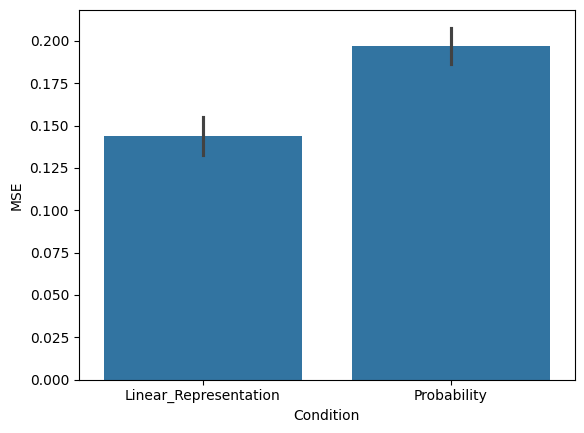

In [42]:
sns.barplot(data=df, x="Condition", y="MSE")
plt.show()

<Axes: xlabel='Human Entropy', ylabel='Model Entropy'>

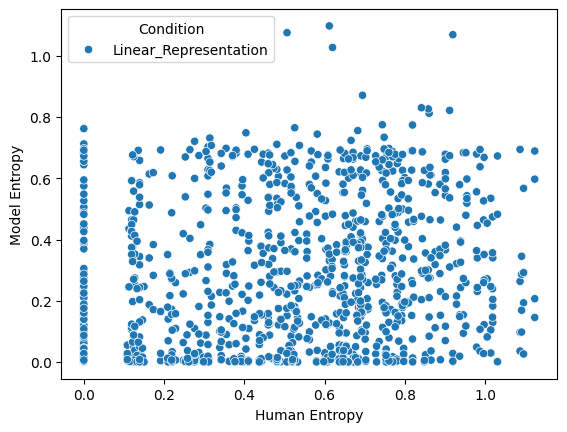

In [44]:
sns.scatterplot(data=df[(df["Dataset"] == "shades") & (df["Condition"] == "Linear_Representation")], x="Human Entropy", y="Model Entropy", hue="Condition")

How well do the GMMs align with experimenter labels

Assign labels to Gaussians:


Entropy of predicted distribution vs. entropy of human distribution (This involves a GMM with just labels that correspond to human classification)



In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.metrics import mean_absolute_error
import scipy

nonsense_labels_mapping = {
    "near": "inconceivable",
    "far": "inconceivable",
    "probable": "probable",
}

goulding_labels_mapping = {
    "impossible": "impossible",
    "possible": "possible",
    "improbable": "possible",
}

shades_labels_mapping = {
    "impossible": "impossible",
    "probable": "probable",
    "improbable": "improbable",
    "inconceivable": "inconceivable",
}

def fit_qda(data, features, dataset):

    labels = data["label"]
    features = data[features]

    # Fit QDA to standard labels
    features = StandardScaler().fit_transform(features)
    qda = QDA().fit(features, labels)

    if dataset == "hu_shades/data":
        mapping = shades_labels_mapping
        corr_class = None
    elif dataset == "hu_nonsense/data":
        mapping = nonsense_labels_mapping
        corr_class = "probable"
    elif dataset == "goulding/adults":
        mapping = goulding_labels_mapping
        corr_class = "impossible"
    else:
        raise ValueError()
    
    ### Compute Projections on to compare the human-subjects classification behavior to the predictions from the
    # generative model
    class_labels = list(mapping.values())
    class_labels.sort()

    # Store results
    kl_divs = []
    mses = []
    model_class_probs = []
    human_class_probs = []

    for idx, row in data.iterrows():
        true_probabilites = np.array(
            [row[class_label] for class_label in class_labels]
        )
            
        sample_features = features[idx]
        predicted_probabilities = qda.predict_proba(sample_features.reshape(1, -1))[0]
        # Process Predicted probabilities
        consolidated_probabilities = np.zeros(len(true_probabilites))
        for pred_idx, cls in enumerate(qda.classes_):
            consolidated_probabilities[class_labels.index(mapping[cls])] += predicted_probabilities[pred_idx]

        # Now, probabilities are consolidated and human judgements and model probabilies are of the same shape
        # Compute Metrics
        kl_div = np.sum(scipy.special.rel_entr(true_probabilites, predicted_probabilities))
        mse = mean_absolute_error(true_probabilites, predicted_probabilities)
        kl_divs.append(kl_div)
        mses.append(mse)

        # For shades data, correlate with whatever the experimenter-defined class is
        if corr_class is None:
            corr_class = row["label"]

        corr_class_idx = class_labels.index(corr_class)
        model_class_probs.append(consolidated_probabilities[corr_class_idx])
        human_class_probs.append(true_probabilites[corr_class_idx])

    ### Save off data
    data["KL Div"] = kl_divs
    data["MSE"] = mses
    data["Model Class Probs"] = model_class_probs
    data["Human Class Probs"] = human_class_probs

    return qda, data

In [7]:
calibration_results = {
    "Model": [],
    "Dataset": [],
    "Condition": [],
    "MSE": [],
    "Pearson R": [],
}

for model in BIG_MODELS:
    for dataset in ["hu_nonsense/data", "hu_shades/data", "goulding/adults"]:
        for condition in ["Linear_Representation", "Probability", "PC", "Random"]:
            if condition == "Probability":
                features = ["Probability"]
            else:
                features = ["probable_improbable", "improbable_impossible", "impossible_inconceivable"]

            path = os.path.join("../results", model, "Calibration", dataset, f"{condition}.csv")
            data = pd.read_csv(path)
            qda, data = fit_qda(data, features, dataset)

            calibration_results["Model"].append(model)
            calibration_results["Dataset"].append(dataset.split("/")[0])
            calibration_results["Condition"].append(condition)
            calibration_results["MSE"].append(data["MSE"].mean())
            calibration_results["Pearson R"].append(scipy.stats.pearsonr(data["Human Class Probs"], data["Model Class Probs"]).statistic)

calibration_results = pd.DataFrame.from_dict(calibration_results)


/gpfs/data/epavlick/mlepori/miniconda3/envs/modal_features/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/gpfs/data/epavlick/mlepori/miniconda3/envs/modal_features/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/gpfs/data/epavlick/mlepori/miniconda3/envs/modal_features/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/gpfs/data/epavlick/mlepori/miniconda3/envs/modal_features/lib/python3.11/site-packages/sklearn/discriminant_analysis.

In [8]:
calibration_results.head()

,Model,Dataset,Condition,MSE,Pearson R
0,allenai/OLMo-2-1124-7B,hu_nonsense,Linear_Representation,0.267220,0.843274
1,allenai/OLMo-2-1124-7B,hu_nonsense,Probability,0.325493,0.526288
2,allenai/OLMo-2-1124-7B,hu_nonsense,PC,0.352490,0.473095
3,allenai/OLMo-2-1124-7B,hu_nonsense,Random,0.368984,0.312238
4,allenai/OLMo-2-1124-7B,hu_shades,Linear_Representation,0.135539,0.612730


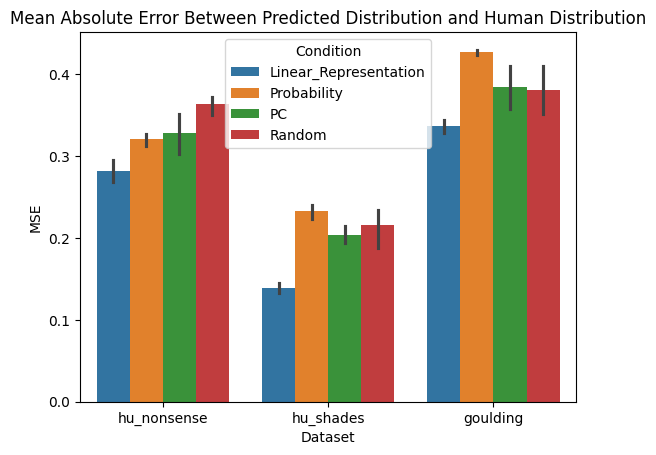

In [9]:
sns.barplot(data=calibration_results, x="Dataset", y="MSE", hue="Condition")
plt.title("Mean Absolute Error Between Predicted Distribution and Human Distribution")
plt.show()

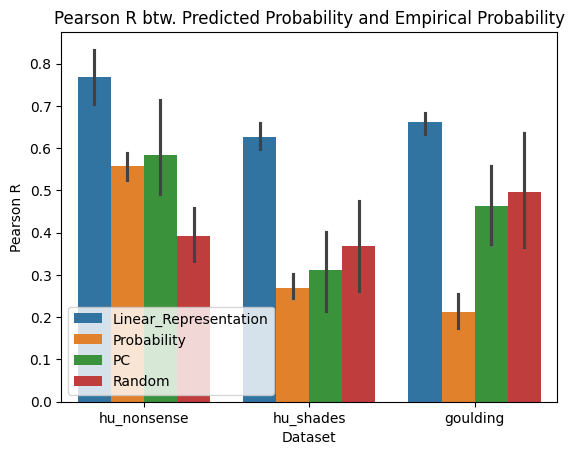

In [11]:
sns.barplot(data=calibration_results, x="Dataset", y="Pearson R", hue="Condition")
plt.title("Pearson R btw. Predicted Probability and Empirical Probability")
plt.legend(loc="lower left")
plt.show()

In [ ]:
import scipy



PearsonRResult(statistic=np.float64(0.6931360235035734), pvalue=np.float64(2.584164282947903e-07))


In [ ]:
# DF to hold all of the classification results

df = {
    "Dataset": [],
    "KL-Div": [],
    "MSE": [],
    "Model": [],
    "Condition": [],
    "Human Label Prob": [],
    "Model Label Prob": [],
}
# Add Shades dataset
for model in ALL_MODELS:
    for condition in CONDITIONS:
        path = os.path.join("../results", model, "Calibration", "hu_shades/data", condition + ".csv")
        data = pd.read_csv(path)
        for _, row in data.iterrows():
            df["Dataset"].append("Shades")
            df["MSE"].append(row["MSE"])
            df["KL-Div"].append(row["KL Div"])
            df["Model"].append(model)
            df["Condition"].append(condition)
            df["Human Label Prob"].append(row[row["label"]])
            df["Model Label Prob"].append(row["Label Class Probs"])

# Add goulding dataset
for model in ALL_MODELS:
    for condition in CONDITIONS:
        path = os.path.join("../results", model, "Calibration", "goulding", "age_9", condition + ".csv")
        data = pd.read_csv(path)

        for _, row in data.iterrows():
            df["Dataset"].append("Goulding")
            df["MSE"].append(row["MSE"])
            df["KL-Div"].append(row["KL Div"])
            df["Model"].append(model)
            df["Condition"].append(condition)
            df["Human Label Prob"].append(row[row["label"]])
            df["Model Label Prob"].append(row["Label Class Probs"])

# Add Nonsense dataset
for model in ALL_MODELS:
    for condition in CONDITIONS:
        path = os.path.join("../results", model, "Calibration", "hu_nonsense/data", condition + ".csv")
        data = pd.read_csv(path)

        for _, row in data.iterrows():
            df["Dataset"].append("Nonsense")
            df["MSE"].append(row["MSE"])
            df["KL-Div"].append(row["KL Div"])
            df["Model"].append(model)
            df["Condition"].append(condition)
            df["Human Label Prob"].append(row[row["label"]])
            df["Model Label Prob"].append(row["Label Class Probs"])

# Turn it into a dataframe
df = pd.DataFrame.from_dict(df)

In [36]:
# Inspect
df.head()

,Dataset,KL-Div,MSE,Model,Condition,Human Label Prob,Model Label Prob
0,Shades,2.118406,2.333175e-01,openai-community/gpt2,Linear_Representation,0.833333,0.121663
1,Shades,0.175488,1.933301e-02,openai-community/gpt2,Linear_Representation,0.525000,0.404270
2,Shades,0.000383,7.348530e-08,openai-community/gpt2,Linear_Representation,1.000000,0.999617
3,Shades,0.455418,5.192360e-02,openai-community/gpt2,Linear_Representation,1.000000,0.634183
4,Shades,1.069679,1.206161e-01,openai-community/gpt2,Linear_Representation,0.820513,0.274882


<Figure size 800x800 with 0 Axes>

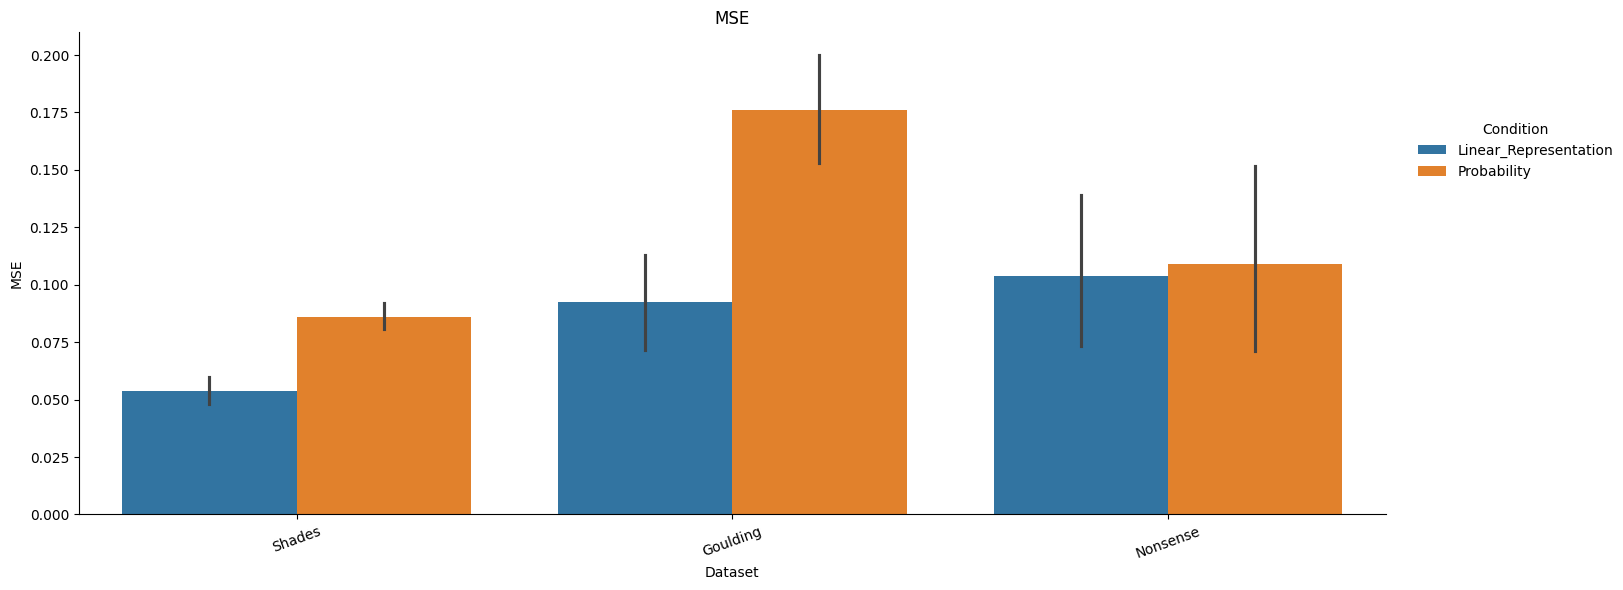

In [40]:
### Plot average over all dataset for each comparison
plt.figure(figsize=(8, 8))
big_df = df[df["Model"].isin(BIG_MODELS)]
g = sns.catplot(data=big_df[big_df["Condition"].isin(["Linear_Representation", "Probability"])], x="Dataset", y="MSE", hue="Condition", kind="bar", height=6, aspect=2)
g._legend.set_bbox_to_anchor((1, .8))
g._legend.set_loc('upper left') 
plt.xticks(rotation=20)
plt.title("MSE")
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

In [41]:
# Compute the correlation between true label and model label probabilities
import scipy
for model in df["Model"].unique():
    print(model)
    for dataset in df["Dataset"].unique():
        curr_df = df[(df["Model"] == model) & (df["Dataset"] == dataset) & (df["Condition"] == "Probability")]
        print(dataset)
        print(scipy.stats.spearmanr(curr_df["Human Label Prob"], curr_df["Model Label Prob"]))


openai-community/gpt2
Shades
SignificanceResult(statistic=np.float64(0.2862794501967637), pvalue=np.float64(1.1087959821711188e-06))
Goulding
SignificanceResult(statistic=np.float64(-0.06385130628812984), pvalue=np.float64(0.5786332965423299))
Nonsense
SignificanceResult(statistic=np.float64(-0.12610056537117278), pvalue=np.float64(0.42038447799300427))
openai-community/gpt2-medium
Shades
SignificanceResult(statistic=np.float64(0.3509567333975321), pvalue=np.float64(1.5454384082934103e-09))
Goulding
SignificanceResult(statistic=np.float64(-0.3083081675101047), pvalue=np.float64(0.00602933190091746))
Nonsense
SignificanceResult(statistic=np.float64(-0.0517050146158374), pvalue=np.float64(0.741942598957827))
openai-community/gpt2-large
Shades
SignificanceResult(statistic=np.float64(0.28627458228924074), pvalue=np.float64(1.1092814637092322e-06))
Goulding
SignificanceResult(statistic=np.float64(-0.11956905274027599), pvalue=np.float64(0.2970861952622489))
Nonsense
SignificanceResult(stati

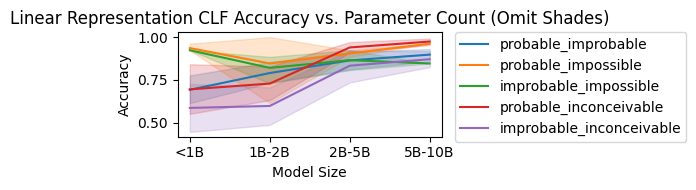

In [183]:
# Plot Size to Performance Comparison
models = df["Model"]
size = []
for model in models:
    for bucket, model_list in PARAM2MODEL.items():
        if model in model_list:
            size.append(bucket)
df["Model Size"] = size

plt.figure(figsize=(6, 2))
linear_representations = df[df["Condition"] == "Linear_Representation"]
sns.lineplot(data=linear_representations[linear_representations["Dataset"] != "Shades"], x="Model Size", y="Accuracy", hue="Comparison", errorbar="ci", err_style="band")
# Move legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Linear Representation CLF Accuracy vs. Parameter Count (Omit Shades)")
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

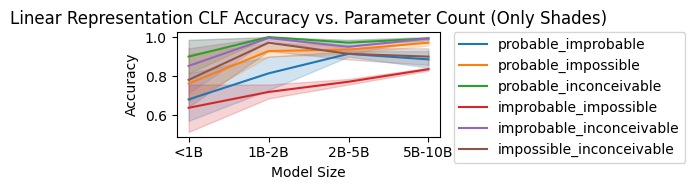

In [184]:
# Plot Size to Performance Comparison
models = df["Model"]
size = []
for model in models:
    for bucket, model_list in PARAM2MODEL.items():
        if model in model_list:
            size.append(bucket)
df["Model Size"] = size

plt.figure(figsize=(6, 2))
linear_representations = df[df["Condition"] == "Linear_Representation"]
sns.lineplot(data=linear_representations[linear_representations["Dataset"] == "Shades"], x="Model Size", y="Accuracy", hue="Comparison", errorbar="ci", err_style="band")
# Move legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Linear Representation CLF Accuracy vs. Parameter Count (Only Shades)")
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

In [185]:
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 800x800 with 0 Axes>

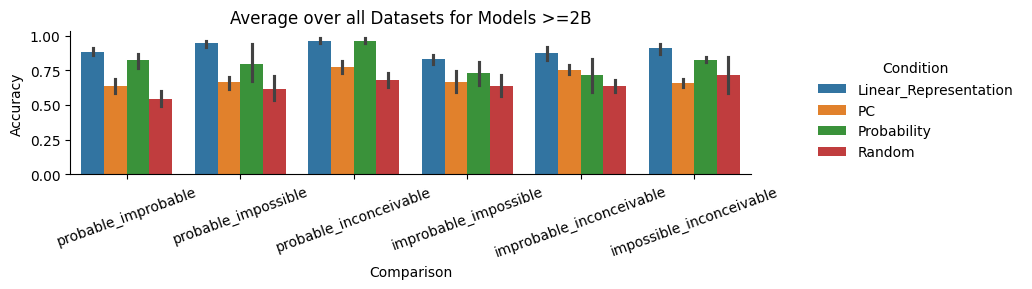

In [186]:
### Plot average over all dataset for each comparison
plt.figure(figsize=(8, 8))
big_df = df[df["Model"].isin(BIG_MODELS)]
g = sns.catplot(data=big_df, x="Comparison", y="Accuracy", hue="Condition", kind="bar", height=3, aspect=2)
g._legend.set_bbox_to_anchor((1, .8))
g._legend.set_loc('upper left') 
plt.xticks(rotation=20)
plt.title("Average over all Datasets for Models >=2B")
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

<Figure size 800x800 with 0 Axes>

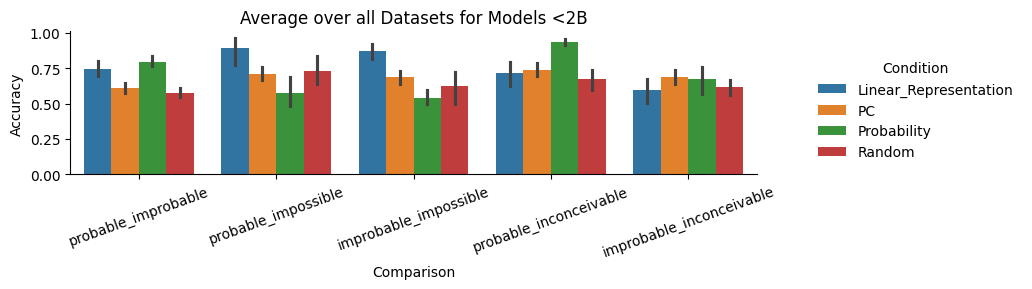

In [ ]:
### Plot average over all dataset for each comparison
plt.figure(figsize=(8, 8))
big_df = df[df["Model"].isin(SMALL_MODELS)]
g = sns.catplot(data=big_df[big_df["Dataset"] != "Shades"], x="Comparison", y="Accuracy", hue="Condition", kind="bar", height=3, aspect=2)
g._legend.set_bbox_to_anchor((1, .8))
g._legend.set_loc('upper left') 
plt.xticks(rotation=20)
plt.title("Average over all Datasets for Models <2B (Omit Shades)")
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

<Figure size 800x800 with 0 Axes>

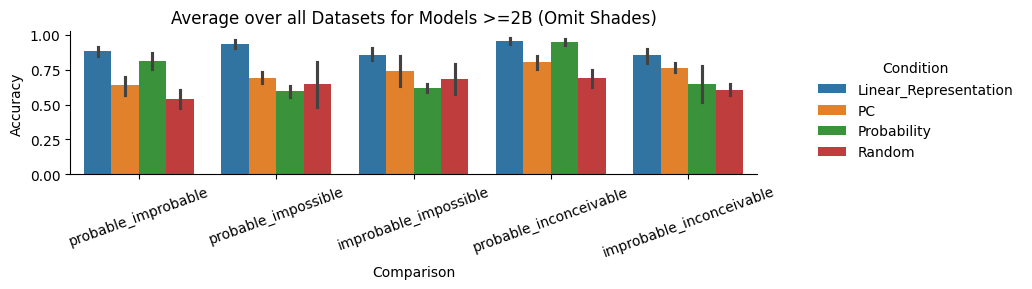

In [187]:
### Plot average over all dataset for each comparison
plt.figure(figsize=(8, 8))
big_df = df[df["Model"].isin(BIG_MODELS)]
g = sns.catplot(data=big_df[big_df["Dataset"] != "Shades"], x="Comparison", y="Accuracy", hue="Condition", kind="bar", height=3, aspect=2)
g._legend.set_bbox_to_anchor((1, .8))
g._legend.set_loc('upper left') 
plt.xticks(rotation=20)
plt.title("Average over all Datasets for Models >=2B (Omit Shades)")
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

<Figure size 640x480 with 0 Axes>

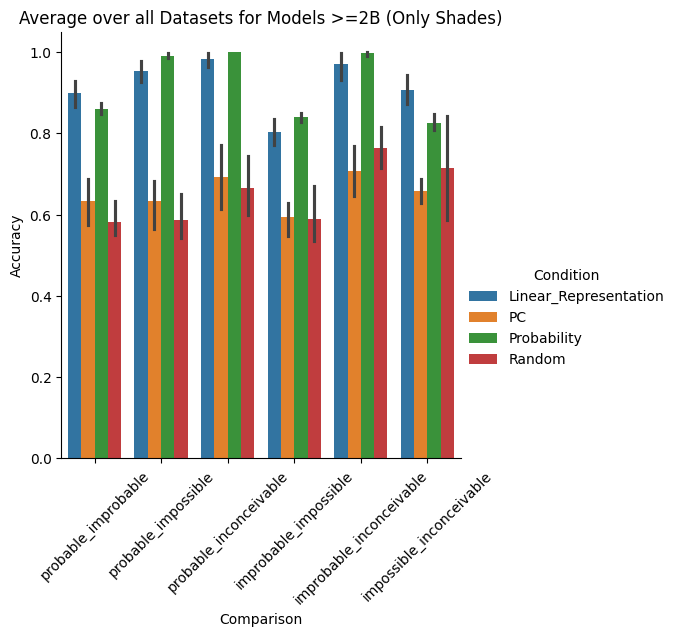

In [188]:
### Plot average over all dataset for each comparison, omit Shades
plt.figure()
big_df = df[df["Model"].isin(BIG_MODELS)]
sns.catplot(data=big_df[big_df["Dataset"] == "Shades"], x="Comparison", y="Accuracy", hue="Condition", kind="bar")
plt.xticks(rotation=45)
plt.title("Average over all Datasets for Models >=2B (Only Shades)")
plt.show()

<Figure size 640x480 with 0 Axes>

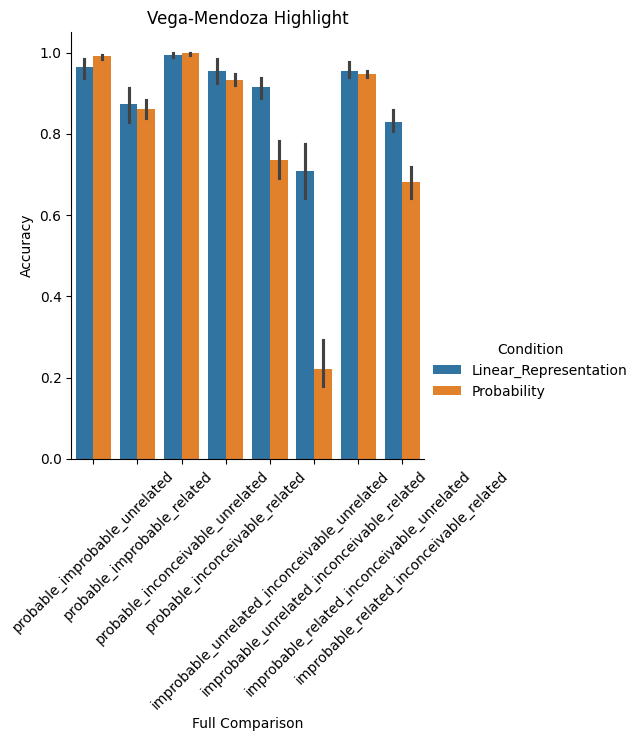

In [189]:
### Highlight Vega-Mendoza
plt.figure()
big_df = df[df["Model"].isin(BIG_MODELS)]
mendoza = big_df[big_df["Dataset"] == "Vega-Mendoza"]
mendoza = mendoza[mendoza["Condition"].isin(["Linear_Representation", "Probability"])]
sns.catplot(data=mendoza, x="Full Comparison", y="Accuracy", hue="Condition", kind="bar")
plt.xticks(rotation=45)
plt.title("Vega-Mendoza Highlight")
plt.show()

In [190]:
## Development of concept vectors through training
# DF to hold all of the classification results

training_df = {
    "Comparison": [],
    "Accuracy": [],
    "Step": [],
}
# Add Shades dataset
comparisons = [
    "probable_improbable",
    "probable_impossible",
    "probable_inconceivable",
    "improbable_impossible",
    "improbable_inconceivable",
    "impossible_inconceivable"
    ]

for model in ALL_MODELS:
    for step in STEP:
        for comparison in comparisons:
            path = os.path.join("../results", "allenai/OLMo-2-1124-7B", "Training_Analysis", str(step), "Linear_Representation", comparison + ".csv")
            mean_acc = process_shades_results(pd.read_csv(path), condition)
            training_df["Step"].append(step)
            training_df["Comparison"].append(comparison)
            training_df["Accuracy"].append(mean_acc)



# Turn it into a dataframe
training_df = pd.DataFrame.from_dict(training_df)
training_df["Log(Step)"] = np.log(training_df["Step"])

/tmp/ipykernel_3568944/2160615757.py:3: UserWarning: 
The markers list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=training_df, x="Step", y="Accuracy", hue="Comparison", style="Comparison", errorbar="ci", err_style="band", markers="o", dashes=False)


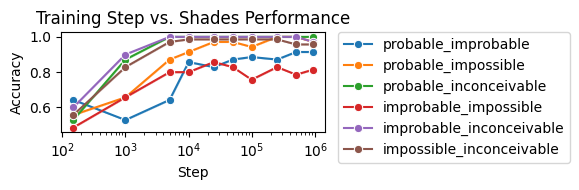

In [191]:
# Plot Train Step to Performance Comparison
plt.figure(figsize=(6, 2))
sns.lineplot(data=training_df, x="Step", y="Accuracy", hue="Comparison", style="Comparison", errorbar="ci", err_style="band", markers="o", dashes=False)
plt.xscale('log')
# Move legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Training Step vs. Shades Performance")
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

In [192]:
# DF to hold all of the classification results

layer_df = {
    "Comparison": [],
    "Accuracy": [],
    "Model": [],
    "Layer": []
}
# Add Shades dataset
comparisons = [
    "probable_improbable",
    "probable_impossible",
    "probable_inconceivable",
    "improbable_impossible",
    "improbable_inconceivable",
    "impossible_inconceivable"
    ]

for model in BIG_MODELS:
    for comparison in comparisons:
        path = os.path.join("../results", model, "Linear_Representation", "Linear_Representation", comparison + ".csv")
        data = pd.read_csv(path)
        max_layer = data["layer"].max()
        for _, row in data.iterrows():
            if row["layer"] == 0:
                continue
            layer_df["Comparison"].append(comparison)
            layer_df["Accuracy"].append(row["accuracy"])
            layer_df["Layer"].append(row["layer"]/max_layer)
            layer_df["Model"].append(model)

# Turn it into a dataframe
layer_df = pd.DataFrame.from_dict(layer_df)

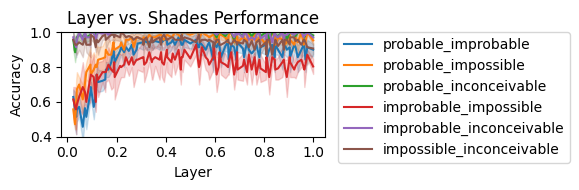

In [193]:
# Plot Train Step to Performance Comparison
plt.figure(figsize=(6, 2))
sns.lineplot(data=layer_df, x="Layer", y="Accuracy", hue="Comparison", errorbar="ci", err_style="band")
# Move legend outside the plot
#plt.xscale("log")
plt.ylim(0.4, 1.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Layer vs. Shades Performance")
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()